In [ ]:
pip install opencv-python


In [ ]:
pip install matplotlib

In [ ]:
train_path = '/home/ppati15/AffectNet/train_class'
val_path = '/home/ppati15/AffectNet/val_class'

In [ ]:
%%javascript
IPython.notebook.clear_all_output();

<IPython.core.display.Javascript object>

In [5]:
import sys

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
import sys
import tensorflow as tf
import tensorflow.keras as keras
print("Python version %s.%s.%s" % sys.version_info[:3])
print("Tensorflow version %s" % tf.__version__)
print("Keras version %s" % keras.__version__)

Python version 3.8.5
Tensorflow version 2.2.0
Keras version 2.3.0-tf


In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [9]:
import cv2

image_1 = cv2.imread(r'/home/ppati15/AffectNet/train_class/class001/image0000002.jpg')

print(type(image_1))
# <class 'numpy.ndarray'>

print(image_1.shape)
print(type(image_1.shape))

<class 'numpy.ndarray'>
(177, 177, 3)
<class 'tuple'>


In [10]:
def get_image(filename):
    image = load_img(filename, target_size=(224, 224))
    np_image = img_to_array(image)
    return np_image

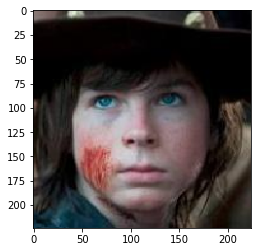

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

image = get_image('/home/ppati15/AffectNet/train_class/class001/image0000002.jpg')
plt.imshow(np.uint8(image))
plt.show()

In [12]:
image.shape

(224, 224, 3)

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization
#from tensorflow.keras.applications import Xception

In [14]:
train_data_gen= ImageDataGenerator(rescale=1./255)
validation_data_gen=ImageDataGenerator(rescale=1./255)

In [15]:
bs=64
cm="categorical"

# load image and label

train_gen=train_data_gen.flow_from_directory(train_path,target_size=(224,224),batch_size=bs,class_mode=cm)
val_gen=validation_data_gen.flow_from_directory(val_path,target_size=(224,224),batch_size=bs,class_mode=cm)

Found 37553 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.


In [16]:
# define input  
input_tensor=Input(shape=(224,224,3))

In [17]:
from tensorflow.keras.applications import ResNet50V2
from keras.models import Model, Sequential
from tensorflow import keras
from keras.layers import GlobalAveragePooling2D, BatchNormalization

model_resnet = ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_tensor)
opt = keras.optimizers.Adam(learning_rate=0.001)
x = model_resnet.output

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024,activation='relu')(x) 
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

preds = Dense(8,activation='softmax')(x) #FC-layer

model = Model(inputs=model_resnet.input, outputs=preds)

# Fix layers                            
for layer in model.layers[:-10]:
    layer.trainable=False

for layer in model.layers[-10:]:
    layer.trainable=True


model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
no_train_img=37553
no_val_img=4000
epochs=25
batch_size=64

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

#early_stop = EarlyStopping(monitor='val_loss',  patience=5, verbose=1)
check_point = ModelCheckpoint('Res50.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='min')
# stop if loss does not improve for 3 iterations

history = model.fit(
       train_gen,
        steps_per_epoch=no_train_img // batch_size,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=no_val_img // batch_size,
        callbacks=[check_point], verbose=1
        )
#early_stop

Epoch 1/25
586/586 [==============================] - ETA: 0s - loss: 2.2357 - accuracy: 0.2823
Epoch 00001: val_loss improved from inf to 1.73895, saving model to Res50.h5
586/586 [==============================] - 971s 2s/step - loss: 2.2357 - accuracy: 0.2823 - val_loss: 1.7390 - val_accuracy: 0.3558
Epoch 2/25
586/586 [==============================] - ETA: 0s - loss: 1.7870 - accuracy: 0.3397
Epoch 00002: val_loss improved from 1.73895 to 1.66011, saving model to Res50.h5
586/586 [==============================] - 936s 2s/step - loss: 1.7870 - accuracy: 0.3397 - val_loss: 1.6601 - val_accuracy: 0.3838
Epoch 3/25
586/586 [==============================] - ETA: 0s - loss: 1.7277 - accuracy: 0.3590
Epoch 00003: val_loss improved from 1.66011 to 1.65973, saving model to Res50.h5
586/586 [==============================] - 942s 2s/step - loss: 1.7277 - accuracy: 0.3590 - val_loss: 1.6597 - val_accuracy: 0.3795
Epoch 4/25
586/586 [==============================] - ETA: 0s - loss: 1.6832 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


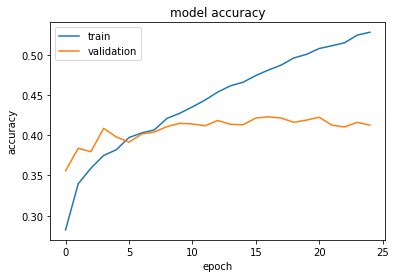

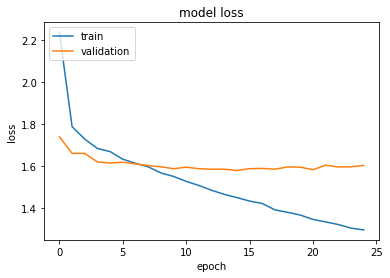

In [19]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()